In [119]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Given the results of https://github.com/tcstewar/testing_notebooks/blob/master/SSP%20encoding%20as%20sine%20wave%20neurons.ipynb we know that SSP encoding can be done by a layer of Sine neurons, and that if you choose the weights correctly you get exactly the same computation as the SSP encoding.

However, we note that the input layer to those neurons use random values choosen uniformly from $[-\pi, \pi]$, with the exception of the first neuron which is forced to have a phase of 0, and there are perfectly aligned pairs of neurons (one for since and one for cosine).  Furthermore, while the output weight matrix is highly structured (it's a variation of the inverse DFT matrix), if we're using random SSPs, then the very next thing we're going to do with that data is to pass it through a random encoder to give that data to neurons.  

This suggests that maybe we don't have to carefully structure our network.  Let's try having random input weight and random weights between the Sine layer and the actual SSP representation layer.  Does this give us the same sort of features as what we see for SSPs?

In [192]:
N = 2
D = 512

import scipy.special
def sparsity_to_x_intercept(d, p):
    p = 1-p
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))

import nengo

# define a sine-wave neuron model
class SineNeuron(nengo.RectifiedLinear):
    def step(self, dt, J, output):
        output[...] = self.amplitude*np.sin(J)

model = nengo.Network()
with model:
    stim = nengo.Node(lambda t: [t,0])
    
    ssp_f = nengo.Ensemble(n_neurons=D, dimensions=N,
                           neuron_type=SineNeuron(amplitude=1/np.sqrt(D/2)),   # set amplitude to scale output to norm=1
                           gain=nengo.dists.Choice([1]),
                           bias=nengo.dists.Uniform(-np.pi, np.pi),      # or Choice([0,np.pi/2])
                           encoders=nengo.dists.Uniform(-np.pi, np.pi),
                           normalize_encoders=False,
                           )
    nengo.Connection(stim, ssp_f, synapse=None)
    
    ssp = nengo.Ensemble(n_neurons=20, dimensions=D,
                         neuron_type=nengo.LIFRate(),
                         intercepts=nengo.dists.Choice([sparsity_to_x_intercept(D, p=0.9)]), # 90% sparse
                        )
    nengo.Connection(ssp_f.neurons, ssp, synapse=None)    
    p_neurons = nengo.Probe(ssp.neurons)
    p_ssp_f = nengo.Probe(ssp_f.neurons)
    
sim = nengo.Simulator(model)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Let's start by looking at the tuning curves of the neurons.  We've asked them to be 90% sparse, and should have a length scale of 1.  We find these by calling `ensemble.tuning_curves` twice, once for each layer:

sparsity: 0.897355


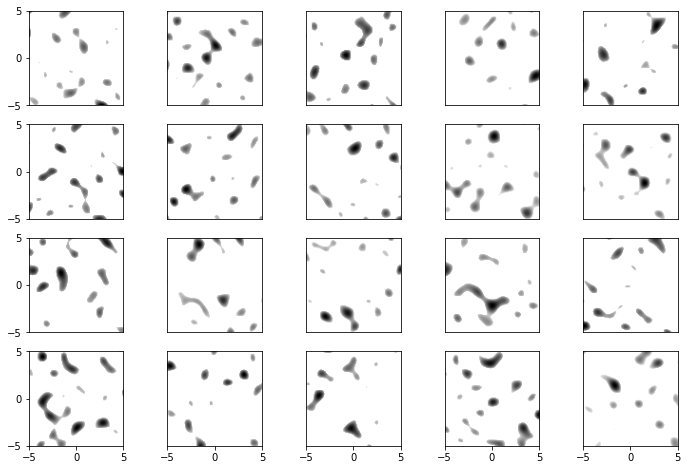

In [194]:
R = 5
S = 100
XX, YY = np.meshgrid(np.linspace(-R, R, S), np.linspace(-R, R, S))
inputs = np.array([XX, YY]).reshape((2,S*S))

_, ssp_a = nengo.utils.ensemble.tuning_curves(ssp_f, sim, inputs=inputs.T)
_, n = nengo.utils.ensemble.tuning_curves(ssp, sim, inputs=ssp_a)

plt.figure(figsize=(12,8))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(n[:,i].reshape((S,S)), extent=(-R, R, -R, R), cmap='gray_r')
    plt.yticks([] if i%5 else [-R,0,R])
    plt.xticks([] if i/5<3 else [-R,0,R])  
print('sparsity:', np.mean(n==0))

Those look like the same sorts of tuning curves as we get with random SSP encoding, and the same math even gives us the right sparsity!

Now let's check what the similarity structure of the vector value we're representing is.  Normally, this would be the output for the Sine neurons multiplied by the inverse DFT matrix, but we can't do that here since we don't have exactly the same structure as that ideal situation (we don't have perfectly paired sine and cosine units).  And so we have the representation of the vector in some weird basis.  But, we don't really care about the vector itself -- we care about the similarity structure of that vector with vectors that represent other points in the space.   Let's plot that similarity structure as we sweep across one dimension.

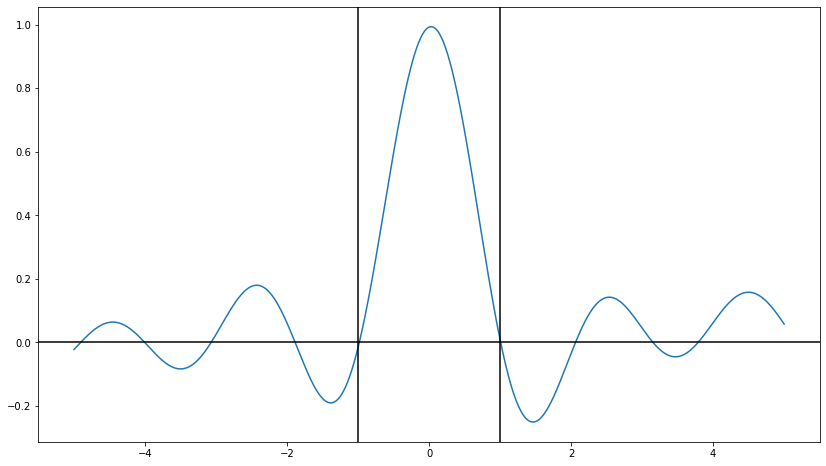

In [195]:
R = 5
S = 1000
XX, YY = np.meshgrid(np.linspace(-R, R, S), [0])
inputs = np.array([XX, YY]).reshape((2,S))

_, ssp_a = nengo.utils.ensemble.tuning_curves(ssp_f, sim, inputs=inputs.T)

plt.figure(figsize=(14,8))
plt.plot(np.linspace(-R,R,S), np.dot(ssp_a, ssp_a[S//2]))
plt.axhline(0, c='k')
plt.axvline(-1, c='k')
plt.axvline(1, c='k')
plt.show()

That has exactly the structure that we're expecting, including the zero-crossings at the integers!

What does this look like in 2D?

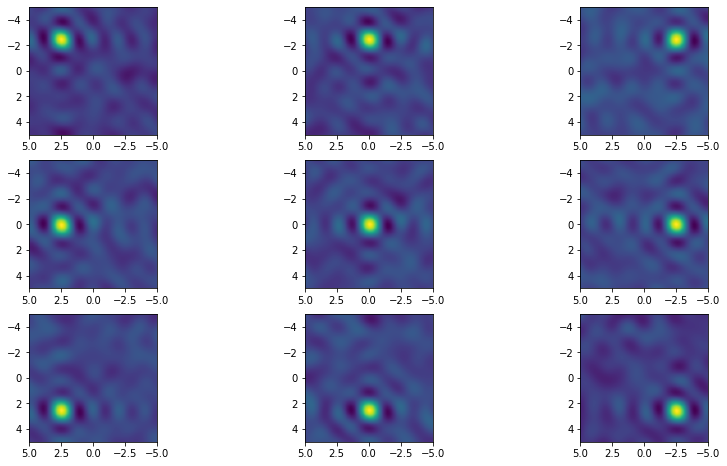

In [196]:
R = 5
S = 100
XX, YY = np.meshgrid(np.linspace(-R, R, S), np.linspace(-R, R, S))
inputs = np.array([XX, YY]).reshape((2,S*S))

_, ssp_a = nengo.utils.ensemble.tuning_curves(ssp_f, sim, inputs=inputs.T)

plt.figure(figsize=(14,8))
pts = [S//4, S//2, 3*S//4]
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,i*3+j+1)
        plt.imshow(np.dot(ssp_a, ssp_a[pts[i]*S+pts[j],:]).reshape((S,S)), extent=(R,-R,R,-R))
plt.show()

This looks like we have the main representational properties that we are looking for!  

I will note that, while this is cool for many applications, one thing this gives up is the whole Algebra aspect.  If we are more careful about how we define the weights, we can still do actual SSP encoding.  But if we don't need the algebra (for example, for things like the Novelty Detection or RL applications), this is a pretty minimal system that should still work fine and might be easier to describe in a paper and to argue for.